In [3921]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import time
import geopy.distance
from geopy.geocoders import Nominatim
import geocoder 
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter
import scipy.stats as stats
import category_encoders as ce
#from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
from ipynb.fs.full.parsing_2 import get_district_details

In [3922]:
df = pd.read_csv('data/country_houses.csv').drop(['Unnamed: 0'], axis=1)
print(df.shape)
print(f"Duplicates found: {df[df.duplicated].shape[0]}")
df.head()


(3052, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,Материал крыши,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2921238,['Дача'],"['4.3', 'сотки']","['29.6', 'м²']",NaN,['1'],['1994'],NaN,['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3152945,['Дача'],"['7', 'соток']","['10', 'м²']",NaN,['1'],['1995'],NaN,['Блочный'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3923]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 109


(2943, 52)

In [3924]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{2,}).", str(x))[0])), 
                        lon=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{2,}).", str(x))[1])),  
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [3925]:
df.drop(['Тип объекта', 'Номер договора', 'Возможен торг', 'Номер дома', 'Условия продажи', 'Аукцион', 'index'], axis=1, inplace=True)

In [3926]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{2,}", x)[0]) if x is not np.nan else x)
        #X['house_readiness'] = pd.cut(X.house_readiness.fillna(np.nan), [0,20,40,60,80,99,100, np.nan], labels = ['<20','20-40','40-60','60-80','80-99','100', 'unknown'])
        X['house_coordinates'] = X['Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{2,}", x)[0]),float(re.findall(r"\d{2}\.\d{2,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(lambda x: float(x.split()[0] + x.split()[1]) if x is not np.nan else x)
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки'], axis=1, inplace=True)

        X = X.fillna({
            'kitchen_area': X['kitchen_area'].median(),
            'house_readiness': X['house_readiness'].median(),
            'liv_house_area': X['liv_house_area'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]        
        

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

In [3927]:
df.drop(['house_length', 'house_width'], axis=1, inplace=True)

In [3928]:
df.columns

Index(['Материал стен', 'Материал крыши', 'Отопление', 'Канализация',
       'Электроснабжение', 'Вода', 'Телефон', 'Область', 'Район',
       'Населенный пункт', 'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли',
       'Сад', 'Хозпостройки', 'Рядом лес', 'Водоем', 'Ландшафтный дизайн',
       'Улица', 'Теплица', 'Мебель', 'Направление', 'Ремонт', 'Камин',
       'Строительные материалы', 'Район города', 'Беседка', 'Микрорайон',
       'Новостройка', 'Бассейн', 'Элитный коттедж', 'Пруд на участке',
       'land_area', 'house_area', 'house_levels', 'house_year',
       'house_readiness', 'house_coordinates', 'price', 'liv_house_area',
       'kitchen_area'],
      dtype='object')

In [3929]:
cat_features = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 
                'Область', 'Район', 'Населенный пункт', 'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли',
                'Сад', 'Хозпостройки', 'Рядом лес', 'Водоем', 'Ландшафтный дизайн', 'Улица', 'Теплица', 'Мебель', 
                'Направление', 'Ремонт', 'Камин', 'Строительные материалы', 'Район города', 'Беседка', 'Микрорайон',
                'Новостройка', 'Бассейн', 'Элитный коттедж', 'Пруд на участке','house_levels', 'house_year', 'house_coordinates']
num_features = ['land_area', 'house_area', 'house_readiness',  'price', 'liv_house_area', 'kitchen_area', 'house_width', 'house_length']


In [3930]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

house_coordinates         2359
Населенный пункт          1566
Сельсовет                  340
Направление                323
Улица                      217
Район                       91
house_year                  74
Материал стен               19
Микрорайон                  18
Материал крыши              13
Вода                        10
Отопление                   10
Район города                 8
Область                      6
Ремонт                       5
Канализация                  5
Электроснабжение             5
house_levels                 4
Статус земли                 4
Газ                          3
Телефон                      2
Бассейн                      1
Новостройка                  1
Элитный коттедж              1
Пруд на участке              1
Беседка                      1
Мебель                       1
Строительные материалы       1
Камин                        1
Теплица                      1
Ландшафтный дизайн           1
Рядом лес                    1
Хозпостр

In [3931]:
df.isna().sum().sort_values(ascending=False)

Элитный коттедж           2928
Бассейн                   2905
Новостройка               2874
Пруд на участке           2871
Микрорайон                2870
Телефон                   2858
Район города              2821
Строительные материалы    2814
Камин                     2611
Улица                     2611
Беседка                   2597
Гараж                     2528
Теплица                   2487
Баня                      2476
Ремонт                    2382
Мебель                    2219
Сад                       2067
Направление               1939
Водоем                    1924
Хозпостройки              1823
Ландшафтный дизайн        1767
Рядом лес                 1456
Газ                       1339
Канализация                966
house_year                 865
Сельсовет                  833
Отопление                  720
Материал крыши             691
house_levels               577
Вода                       404
Электроснабжение           384
Статус земли               372
Материал

### Binary categories

In [3932]:
bin_categories = categories[categories<=2]  
print(bin_categories)

Телефон                   2
Бассейн                   1
Новостройка               1
Элитный коттедж           1
Пруд на участке           1
Беседка                   1
Мебель                    1
Строительные материалы    1
Камин                     1
Теплица                   1
Ландшафтный дизайн        1
Рядом лес                 1
Хозпостройки              1
Сад                       1
Гараж                     1
Баня                      1
Водоем                    1
dtype: int64


In [3933]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    345
Name: count, dtype: int64

Камин
['Да']    331
Name: count, dtype: int64

Телефон
['Есть']             83
['2', 'телефона']     1
Name: count, dtype: int64

In [3934]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        

    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

In [3935]:
def draw_categories(features, ax_width=10, tick_rotation=30):
    n = len(features) 
    fig, axes = plt.subplots(n, 2, figsize=(ax_width, n*3)) 

    for i, feature in enumerate(features):
        #print(n,i,feature)
        count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
        sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0], width=0.4).set(title=f'{feature} (ratio)', xlabel='');
        axes[i][0].xaxis.set_tick_params(rotation=tick_rotation)
        sns.barplot(df, x=feature, y='price', ax=axes[i][1], width=0.4).set(title=f'{feature} (price)', xlabel='');
        axes[i][1].xaxis.set_tick_params(rotation=tick_rotation)
    plt.tight_layout() 
    
#draw_categories(bin_categories.index, tick_rotation=0)

### Multi options categories 

In [3936]:
multi_categories = categories[categories>2]
display(multi_categories)


house_coordinates    2359
Населенный пункт     1566
Сельсовет             340
Направление           323
Улица                 217
Район                  91
house_year             74
Материал стен          19
Микрорайон             18
Материал крыши         13
Вода                   10
Отопление              10
Район города            8
Область                 6
Ремонт                  5
Канализация             5
Электроснабжение        5
house_levels            4
Статус земли            4
Газ                     3
dtype: int64

In [3937]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Микрорайон           2870
Район города         2821
Улица                2611
Ремонт               2382
Направление          1939
Газ                  1339
Канализация           966
house_year            865
Сельсовет             833
Отопление             720
Материал крыши        691
house_levels          577
Вода                  404
Электроснабжение      384
Статус земли          372
Материал стен         344
Район                   5
Область                 0
Населенный пункт        0
house_coordinates       0
dtype: int64

In [3938]:
df = df.drop(['Микрорайон', 'Район города', 'Улица'], axis=1)

In [3939]:
alpha = 0.05

def stat_compare(category, category_opt_1, category_opt_2, alpha=alpha):
    """ Assess if the difference between feature options is statistically significant

    Args:
        category (_type_): _description_
        category_opt_1 (_type_): _description_
        category_opt_2 (_type_): _description_
        alpha (_type_, optional): _description_. Defaults to alpha.

    Returns:
        _type_: _description_
    """
        
    opt_1 = df[df[category]==category_opt_1]['price']
    opt_2 = df[df[category]==category_opt_2]['price']
    max_opt = df[df[category].isin([category_opt_1,category_opt_2])][category].value_counts().idxmax()

    def get_normality(data, alpha=alpha):
        _, p = stats.shapiro(data)
        if p <= alpha:
            return 1
        else:
            return 0
    
    def test_t(data_1, data_2, alpha=alpha):
        result = stats.levene(data_1, data_2)
        p = result[1]
        if p <= alpha:
            equal_var=False
        else:
            equal_var=True

        _, p = stats.ttest_ind(data_1, data_2, alternative='two-sided', equal_var=True)
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'


    def test_mannwhit(data_1, data_2, alpha=alpha):
        _, p = stats.mannwhitneyu(data_1, data_2, alternative='two-sided')
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'
    
    norm_1 = get_normality(opt_1)
    norm_2 = get_normality(opt_2)

    if norm_1==0 and norm_2==0:
        res = test_t(opt_1,opt_2)
        if res == 'equal':
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res.upper()} --> {max_opt}"
        else:
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}"
    else:
        res = test_mannwhit(opt_1,opt_2)
        if res == 'equal':
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res.upper()} --> {max_opt}"
        else:
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}" 
    

In [3940]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ', 'Ремонт']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен']
fill_na_find = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year']


In [3941]:
print(stat_compare('Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare('Канализация', "['Местная']", "['Центральная']"))

print(stat_compare('Электроснабжение', "['Рядом']", "['Нет']"))
print(stat_compare('Электроснабжение', "['Есть']", "['220В']"))

print(stat_compare('Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare('Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare('Вода', "['Нет']", "['Рядом']"))

print(stat_compare('Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare('Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))

print(stat_compare('Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

КАНАЛИЗАЦИЯ ['С/у', 'на', 'улице'] (1), ['Нет'] (1): EQUAL --> ['С/у', 'на', 'улице']
КАНАЛИЗАЦИЯ ['Местная'] (1), ['Центральная'] (0): EQUAL --> ['Местная']
ЭЛЕКТРОСНАБЖЕНИЕ ['Рядом'] (1), ['Нет'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Есть'] (1), ['220В'] (1): EQUAL --> ['Есть']
ВОДА ['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
ВОДА ['Рядом', 'водопровод'] (1), ['Рядом'] (1): not equal
ВОДА ['Нет'] (1), ['Рядом'] (1): EQUAL --> ['Рядом']
РЕМОНТ ['Евроотделка,', 'отделка', 'деревом'] (0), ['Евроотделка'] (1): EQUAL --> ['Евроотделка']
РЕМОНТ ['Не', 'достроен,', 'отделка', 'деревом'] (1), ['Не', 'достроен'] (1): EQUAL --> ['Не', 'достроен']
ОТОПЛЕНИЕ ['На', 'газу'] (1), ['Паровое'] (0): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (0): EQUAL --> ['Паровое', 'на', 'твёрдом', 'топливе']
ОТОПЛЕНИЕ ['Паровое', 'на', 'жидком', 'топливе'] (0), ['Паровое'] (0): EQUAL --> ['Паровое', 'на', 'жидком', 'топливе']


In [3942]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет'
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'нет', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'местная', 
            "['Нет']":'нет',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'есть', 
            "['220В']":'есть', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['Печное']":'печь', 
            "['Нет']":'нет', 
            "['На', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Электрическое']":'электрич.',
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'газу']":'паровое г.',
            })
        
        X['Вода'] = X['Вода'].map({
            "['Сезонная']":'сезонная', 
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец', 
            "['Центральный', 'водопровод']":'центральн.',
            "['Холодная']":'холодная',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Рядом']":'нет',
            "['Горячая']":'горячая',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом водопр'
            })

        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен',
            })


        X[self.categories] = X[self.categories].fillna('нет')

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

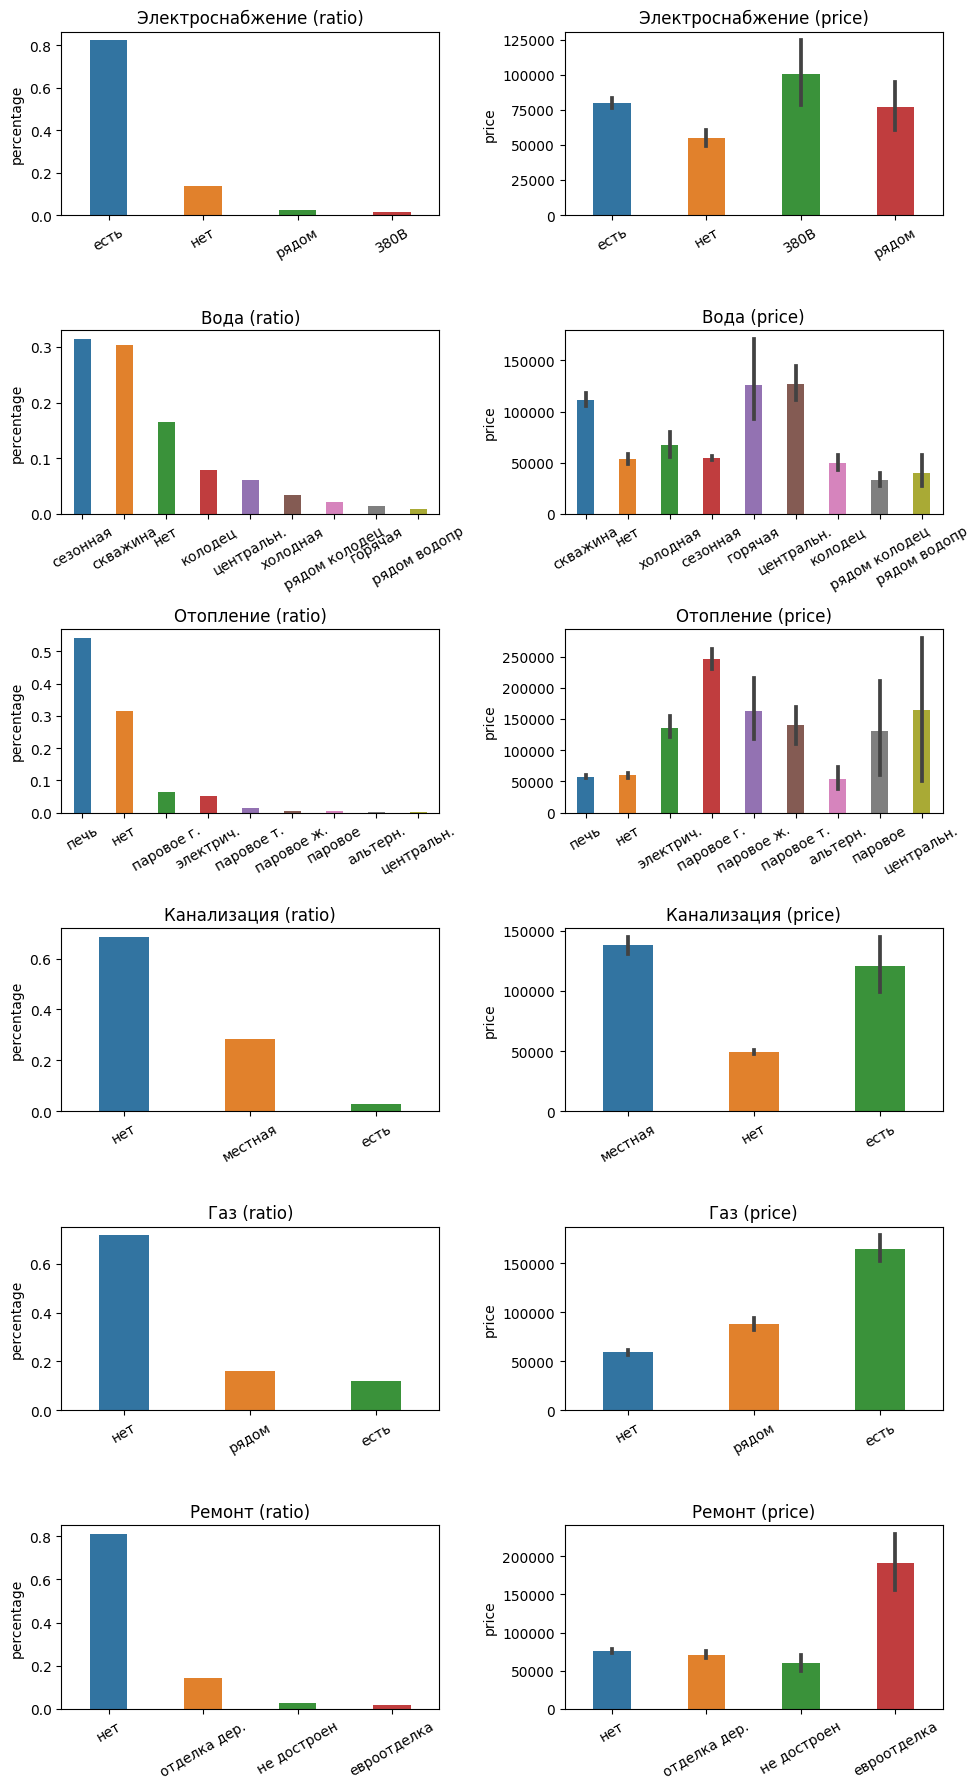

In [3943]:
draw_categories(fill_na_net)

In [3944]:
print(stat_compare('Материал стен', "['Блок', 'газосиликатный']", "['Блочный']"))
print(stat_compare('Материал стен', "['Белый', 'кирпич']", "['Кирпичный']"))
print(stat_compare('Материал стен', "['Каркасный', 'деревянный']", "['Каркасно-засыпной']"))
print(stat_compare('Материал стен', "['Красный', 'кирпич']", "['Кирпичный']"))
print(stat_compare('Материал стен', "['Дерево']", "['Сруб']"))

print(stat_compare('Материал крыши', "['Металло-черепица']", "['Металл']"))
print(stat_compare('Материал крыши', "['Ондулин']", "['Евро-шифер']"))
print(stat_compare('Материал крыши', "['Мягкая', 'черепица']", "['Битумная', 'черепица']"))
print(stat_compare('Материал крыши', "['Жесть']", "['Металл']"))
print(stat_compare('Материал крыши', "['Рубероид']", "['Гидроизоляция']"))



МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Кирпичный'] (1): EQUAL --> ['Кирпичный']
МАТЕРИАЛ СТЕН ['Каркасный', 'деревянный'] (1), ['Каркасно-засыпной'] (1): EQUAL --> ['Каркасный', 'деревянный']
МАТЕРИАЛ СТЕН ['Красный', 'кирпич'] (1), ['Кирпичный'] (1): EQUAL --> ['Кирпичный']
МАТЕРИАЛ СТЕН ['Дерево'] (1), ['Сруб'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Металло-черепица'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Ондулин'] (1), ['Евро-шифер'] (1): EQUAL --> ['Ондулин']
МАТЕРИАЛ КРЫШИ ['Мягкая', 'черепица'] (1), ['Битумная', 'черепица'] (0): not equal
МАТЕРИАЛ КРЫШИ ['Жесть'] (1), ['Металл'] (1): EQUAL --> ['Металл']
МАТЕРИАЛ КРЫШИ ['Рубероид'] (1), ['Гидроизоляция'] (0): not equal


In [3945]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Сруб']":'сруб',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Белый', 'кирпич']":'кирпич',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Брус', 'профилированный']":'брус профил.',
            "['Каркасно-засыпной']":'каркасн. дер.',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Красный', 'кирпич']":'кирпич',
            "['Облицовочный', 'кирпич']":'кирпич облиц.',
            "['Панельный']":'панельн.',
            "['Керамзитбетон']":'керамзитобетон',
            "['Шлакобетон']":'шлакобетон',
            "['Брус', 'клееный']":'брус клеен.',
            "['Монолитно-каркасный']":'каркасн. монол.'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер', 
            "['Металло-черепица']":'черепица мет.', 
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Евро-шифер']":'ондулин',
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Битумная', 'черепица']":'черепица бит.',
            "['Жесть']":'металл',
            "['Рубероид']":'рубероид',
            "['Гидроизоляция']":'гидроизоляция',
            "['Доски']":'доски',
            "['Природные', 'материалы']":'природн.'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная']":'частная', 
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн.', 
            "['Другое']":'частная', 
            "['Аренда']":'аренда',
            })

        #largest_roof = df['Материал крыши'].value_counts().nlargest(10).index
        #X['Материал крыши'] = X['Материал крыши'].apply(lambda x: x if x in largest_roof else ('другой' if x is not np.nan else x))

        #largest_wall = df['Материал стен'].value_counts().nlargest(10).index
        #X['Материал стен'] = X['Материал стен'].apply(lambda x: x if x in largest_wall else 'другой')
        
        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

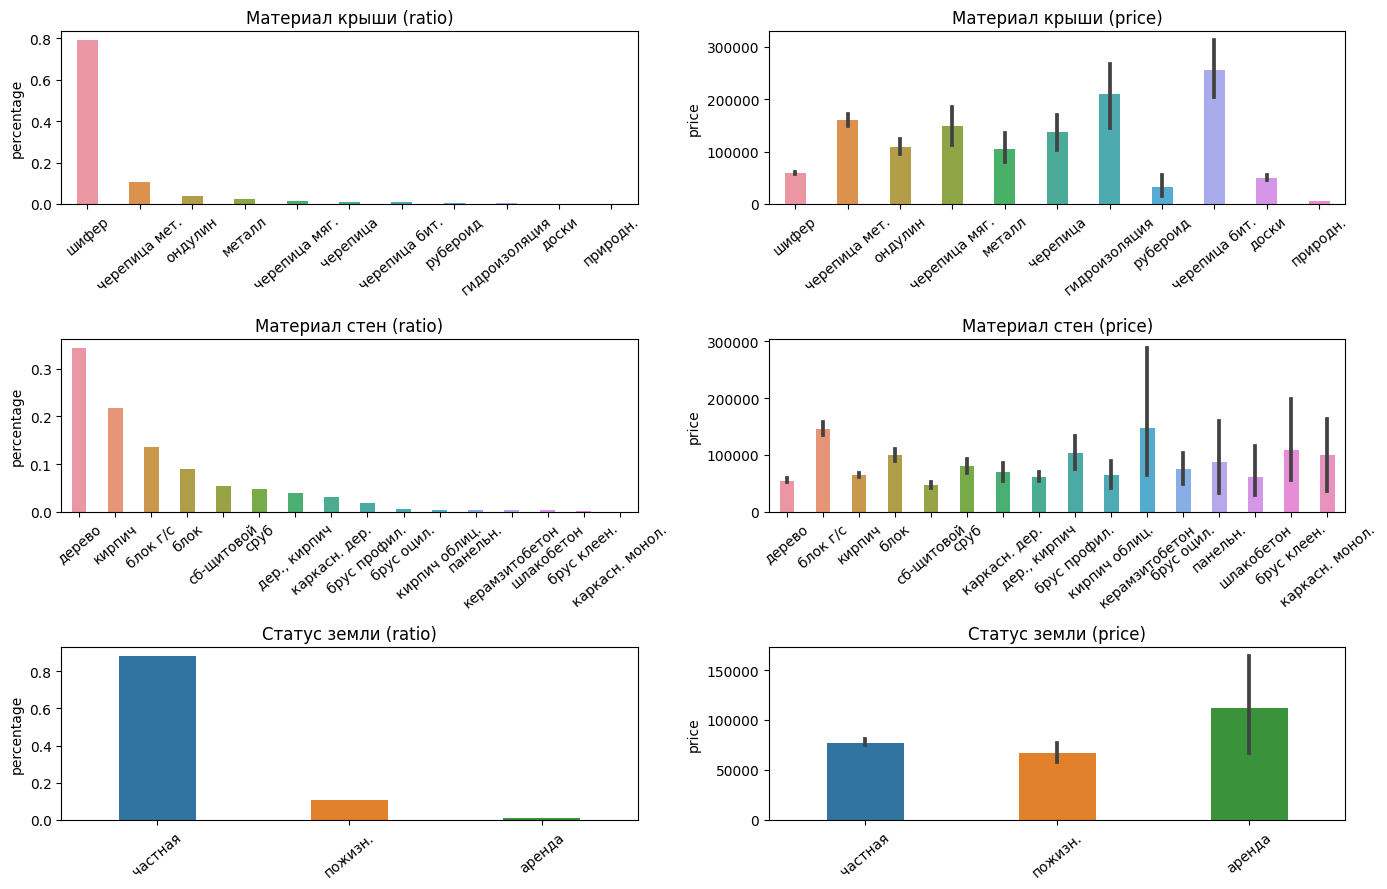

In [3946]:
draw_categories(['Материал крыши', 'Материал стен', 'Статус земли'], 14, 40)

In [3947]:
df = df[~(df['house_year']<1960)]
df.shape

(2919, 40)

In [3948]:
district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')

In [3949]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
              
        #X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        #X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
        X['year_group'] = pd.cut(X.house_year, [0,1980,1990,2000,2010,2020,9999], labels = ['<1980','1980-1990','1990-2000','2000-2010','2010-2020','2020+'])
        X['year_group'] = df['year_group'].fillna(df['year_group'].mode()[0])


        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        def clean_name(value):
            try:
                res = re.findall(r'\'(\w+)\'',value.replace('-',''))
                return res[0]
            except:
                return value
            
        
        X['Сельсовет'] = X['Сельсовет'].apply(lambda x: clean_name(x))
        X['Сельсовет'] = X['Сельсовет'].fillna(X.groupby('Населенный пункт')['Сельсовет'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        X['Сельсовет'] = X['Сельсовет'].fillna('unknown')

        X['Район'] = X['Район'].apply(lambda x: clean_name(x))
        X.loc[X[X['Населенный пункт']=="['г.', 'Минск']"].index,'Район'] = 'г.Минск'
        X = X[X['Район'].notna()]
        
        df_district = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
        X = pd.merge(X, df_district, how='left', on='Район')

        largest_districts = df['Район'].value_counts().nlargest(30).index
        X['Район'] = X['Район'].apply(lambda x: x if x in largest_districts else 'другой')
        
        
        X.drop(['Направление', 'house_year'], axis=1, inplace=True)
                

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_find)
df = cat_3_treat.transform(df)


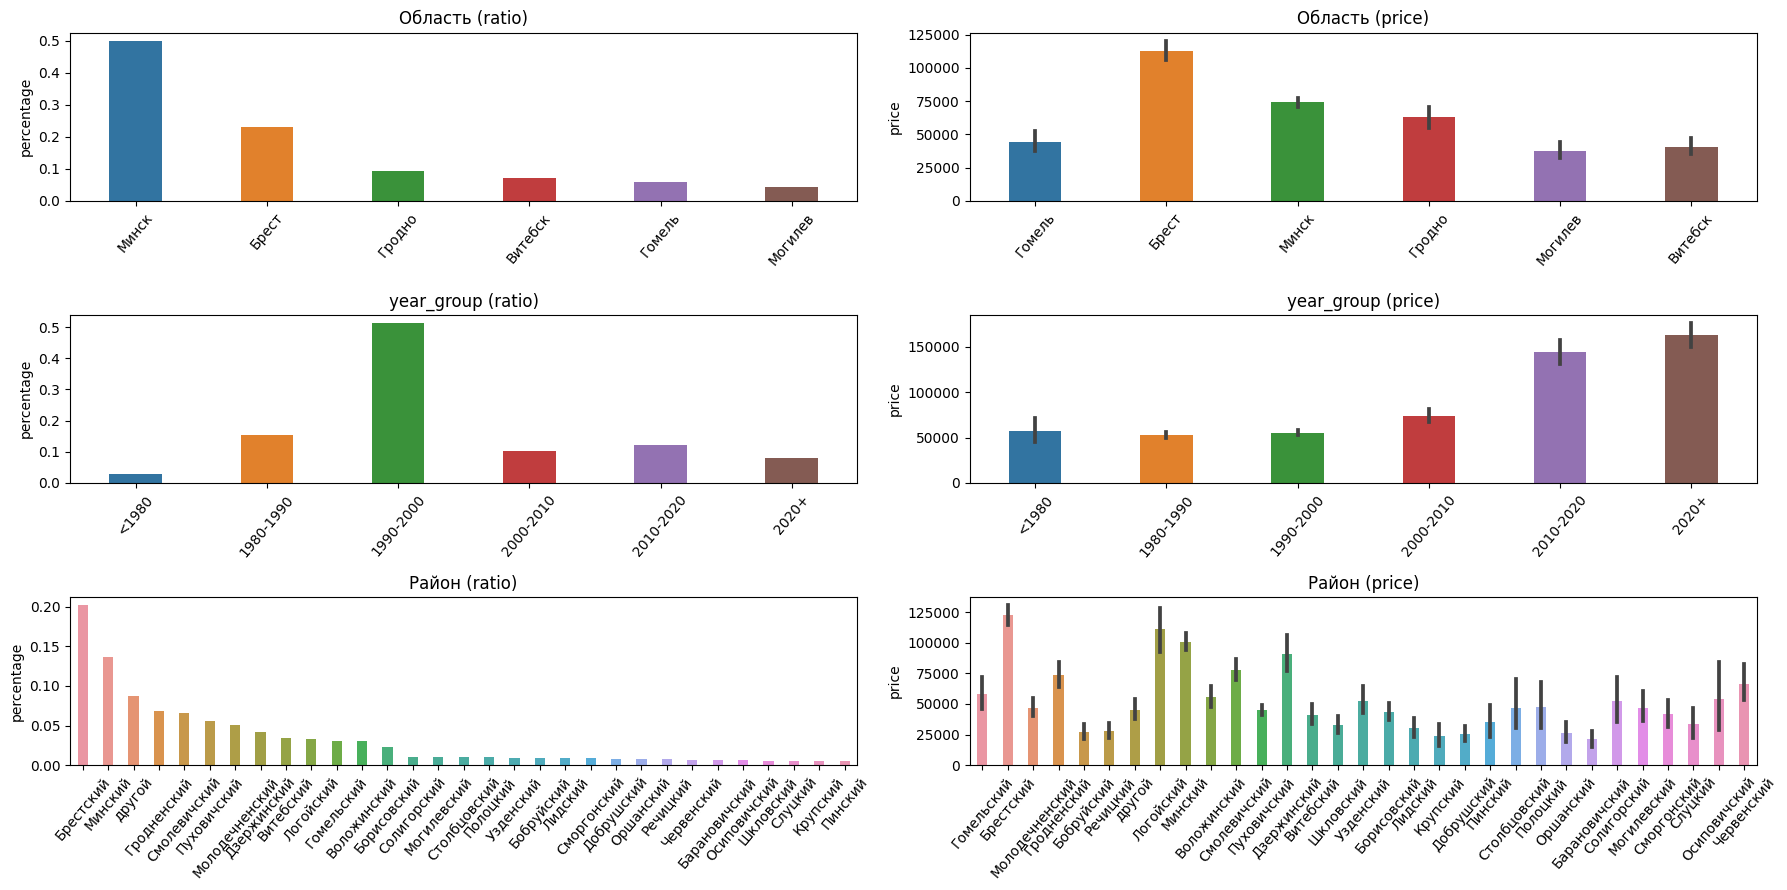

In [3950]:
draw_categories(['Область', 'year_group', 'Район'], 18, 50)

In [3951]:
print(df.shape)
df = df[~((df['year_group']=='<1980') & (df['price']>df['price'].median()))]
print(df.shape)


(2918, 41)
(2887, 41)


### New features

In [3952]:
def get_location(name):
    try:
        g = geocoder.bing(name, key='AgY4Qy8qL2I1oMf6xu6SSpqncKEFzpjZIKzs3Y_lhKvdA4cRPMUpBEIDmgXxm5_e')
        results = g.json
        #print(name, results['lat'], results['lng'])
        return (results['lat'], results['lng'])
    except:
        print('exception', name)
        return name


regions_dict = dict()
regions = df['Область'].unique()
for item in regions:
    if type(item) is str:
        regions_dict[item] = get_location(item + ', беларусь')
    else:
        continue

regions_dict


{'Гомель': (52.4191246, 30.97227287),
 'Брест': (52.0941124, 23.7319088),
 'Минск': (53.897686, 27.54942131),
 'Гродно': (53.67042542, 23.82331085),
 'Могилев': (53.90841293, 30.34563446),
 'Витебск': (55.1845932, 30.20467567)}

In [3953]:
df['regional_center_coordinates'] = df['Область'].apply(lambda x: str(regions_dict[x]) )

In [3954]:
def get_distance(d1,d2,extra=0):
    coord1 = str(d1).replace(',',' ').lstrip('(').rstrip(')').split()
    coord2 = d2.replace(',',' ').lstrip('(').rstrip(')').split()
    distance = geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (float(coord2[0]),float(coord2[1]))).km

    if extra == 0:
        return round(distance,1)
    else:
        distances = dict()
        for key in regions_dict:
            distances[key] = geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (regions_dict[key][0],regions_dict[key][1])).km
        distance_region_min = min(distances.values())
        return(round(distance,1), round(distance_region_min,1))

df['distance_house_district_center'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
#df['distance_house_district_city'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_city_coordinates']), axis=1)
#df['distance_house_region'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[0], axis=1)
df['distance_house_region_min'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[1], axis=1)
df['distance_house_minsk'] = df.apply(lambda x: get_distance(x['house_coordinates'], str(regions_dict['Минск'])), axis=1)

#dfc.loc[400:410, ['Населенный пункт','Район','distance_house_district_center', 'distance_house_district_city', 'distance_house_region','distance_house_region_min','distance_house_minsk']]




In [3955]:
df[['distance_house_district_center','distance_house_region_min','distance_house_minsk']].describe()

,distance_house_district_center,distance_house_region_min,distance_house_minsk
count,2887.000000,2887.000000,2887.000000
mean,31.296883,38.086214,153.121545
std,17.046288,36.577818,121.543732
min,1.600000,1.700000,7.900000
25%,19.200000,11.900000,33.400000
50%,28.400000,26.700000,122.000000
75%,40.700000,47.250000,285.100000
max,233.000000,205.900000,358.900000


In [3956]:
#f,a = plt.subplots(figsize=(10,10))
#sns.heatmap(dfc.corr(numeric_only=True))

In [3957]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 
            'Вода','Область',  'Газ', 'Статус земли', 'Ремонт', 'Район','year_group']

encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
add = encoder.fit_transform(df.loc[:,ohe_list])
dff = pd.concat([df,add], axis=1).drop(ohe_list, axis=1)

dff.head()

,Телефон,Населенный пункт,Сельсовет,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,...,Район_Сморгонский,Район_Слуцкий,Район_Осиповичский,Район_Червенский,year_group_<1980,year_group_1980-1990,year_group_1990-2000,year_group_2000-2010,year_group_2010-2020,year_group_2020+
0,1,"['с/т', 'Родны', 'кут']",Бобовичский,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,"['Знаменский', 'с/с']",Знаменский,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,"['с/т', 'АЛМАЗ-2002']",Лебедевский,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,"['с/т', 'Южное-2']",Знаменский,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,"['с/т', 'Колос-Жиличи']",Коптёвский,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [3958]:
#dff = dff.drop(ohe_list, axis=1)
dff = dff.drop(['house_coordinates','regional_center_coordinates','district_center_coordinates', 'district_city_coordinates', 'Населенный пункт', 'Сельсовет'], axis=1)
dff.head(5)

,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Район_Сморгонский,Район_Слуцкий,Район_Осиповичский,Район_Червенский,year_group_<1980,year_group_1980-1990,year_group_1990-2000,year_group_2000-2010,year_group_2010-2020,year_group_2020+
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


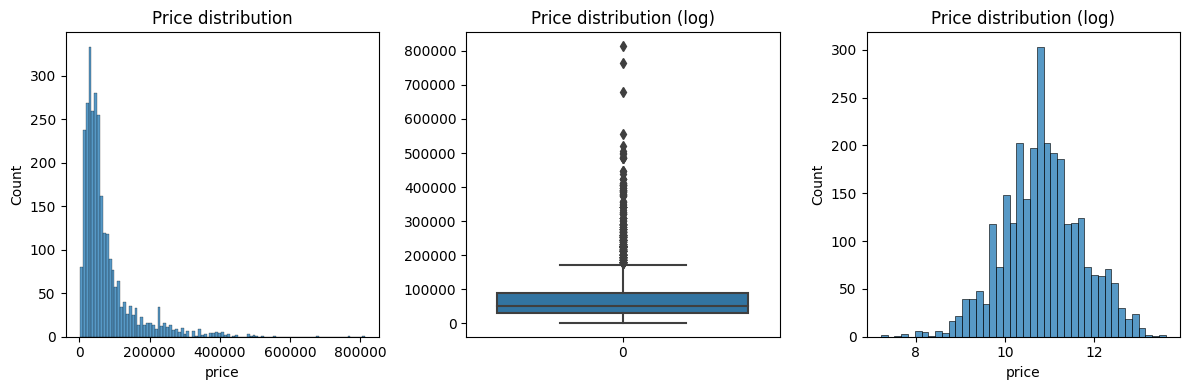

In [3959]:
f,a = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(dff['price'], ax=a[0]).set(title='Price distribution');
sns.boxplot(dff['price'], ax=a[1]).set(title='Price distribution (log)');
sns.histplot(np.log(dff['price']), ax=a[2]).set(title='Price distribution (log)');

plt.tight_layout()

In [3960]:
def outliers_z_score(data, feature, log_scale=False):
    """_summary_

    Args:
        data (_type_): _description_
        feature (_type_): _description_
        log_scale (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3.0 * sigma
    upper_bound = mu + 3.0 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, dff_cleaned = outliers_z_score(dff, 'price', log_scale=True)

print('Shape before cleaning outliers: {}'.format(dff.shape))
print('Shape after cleaning outliers: {}'.format(dff_cleaned.shape))

Shape before cleaning outliers: (2887, 132)
Shape after cleaning outliers: (2873, 132)


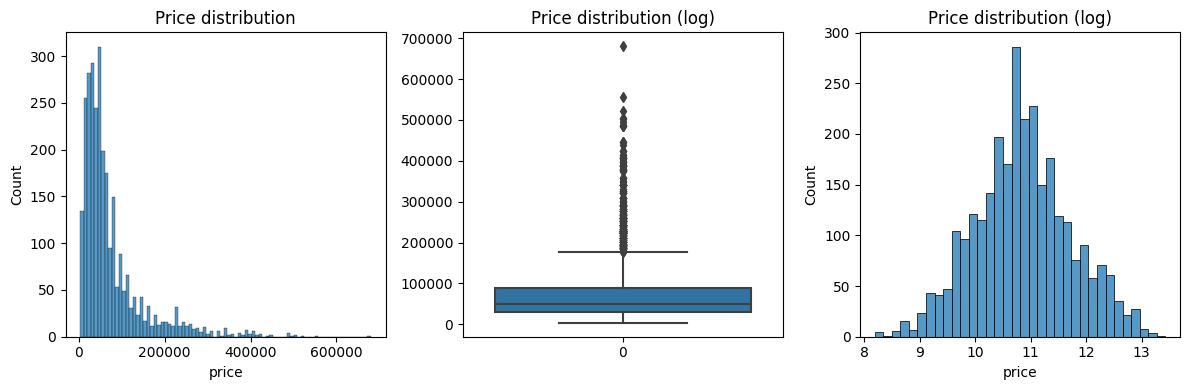

In [3961]:
f,a = plt.subplots(1, 3, figsize=(12,4))

sns.histplot(dff_cleaned['price'], ax=a[0]).set(title='Price distribution');
sns.boxplot(dff_cleaned['price'], ax=a[1]).set(title='Price distribution (log)');
sns.histplot(np.log(dff_cleaned['price']), ax=a[2]).set(title='Price distribution (log)');

plt.tight_layout()

### Models

In [3962]:
X = dff_cleaned.drop('price', axis=1)
y = dff_cleaned['price']
col_names = X.columns



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
y_train_log = np.log(y_train)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_df = pd.DataFrame(X_train, columns=col_names)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

X_train_df.head()


Train shape: (2298, 131)
Test shape: (575, 131)


,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Район_Сморгонский,Район_Слуцкий,Район_Осиповичский,Район_Червенский,year_group_<1980,year_group_1980-1990,year_group_1990-2000,year_group_2000-2010,year_group_2010-2020,year_group_2020+
1691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1120,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1555,0,0,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1508,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3963]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    #print('Train MSE: {:.3f}'.format(metrics.mean_squared_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    #print('Test MSE: {:.3f}'.format(metrics.mean_squared_error(y_test, y_test_predict)*100))

In [3964]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [3965]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.687
Train MAE: 28297.873
Train MAPE: 57.974


Test R^2: 0.684
Test MAE: 26113.209
Test MAPE: 66.241


In [3966]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train_scaled, y_train_log) 

y_train_pred = np.exp(gs.predict(X_train_scaled))
y_test_pred = np.exp(gs.predict(X_test_scaled))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.775
Train MAE: 21139.035
Train MAPE: 32.600


Test R^2: 0.766
Test MAE: 20388.432
Test MAPE: 41.038


In [ ]:
def optuna_rf(trial):
    """_summary_

    Args:
        trial (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=33
        )
  
    model.fit(X_train_scaled, y_train_log)
    #score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))
    score_test = metrics.r2_score(y_test, np.exp(model.predict(X_test_scaled)))
    score_train = metrics.r2_score(y_train, np.exp(model.predict(X_train_scaled)))
    score = score_test / (score_train-score_test)

    return score


#study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
#study.optimize(optuna_rf, n_trials=20)

#print(f"Best hyperparameters {study.best_params}")
#print(f"r2-score for TRAIN set: {study.best_value}")

#--> Best hyperparameters {'n_estimators': 129, 'max_depth': 25, 'min_samples_leaf': 10}

In [ ]:
#rfr = RandomForestRegressor(**study.best_params,random_state=33)
rfr = RandomForestRegressor(n_estimators= 129, max_depth = 25, min_samples_leaf = 10,random_state=33)

rfr.fit(X_train_scaled, y_train_log)

y_train_pred = np.exp(rfr.predict(X_train_scaled))
y_test_pred = np.exp(rfr.predict(X_test_scaled))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.736
Train MAE: 22029.274
Train MAPE: 33.702


Test R^2: 0.720
Test MAE: 22255.622
Test MAPE: 44.145


In [3967]:
train_scores_r2 = []
test_scores_r2 = []
train_scores_mae = []
test_scores_mae = []

for i in np.arange(20, X_train.shape[1],20):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train_log)
    best_fea = selector.get_feature_names_out()

    params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

    gs = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=33), 
        param_grid=params,
        scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
        cv=3, 
        n_jobs = -1
    )  

    gs.fit(X_train[best_fea], y_train_log) 

    y_train_pred = np.exp(gs.predict(X_train[best_fea]))
    y_test_pred = np.exp(gs.predict(X_test[best_fea]))

    train_scores_r2.append(metrics.r2_score(y_train, y_train_pred))
    test_scores_r2.append(metrics.r2_score(y_test, y_test_pred))
    train_scores_mae.append(metrics.mean_absolute_error(y_train, y_train_pred))
    test_scores_mae.append(metrics.mean_absolute_error(y_test, y_test_pred))
    #metrics.mean_absolute_error(y_test, y_test_pred)


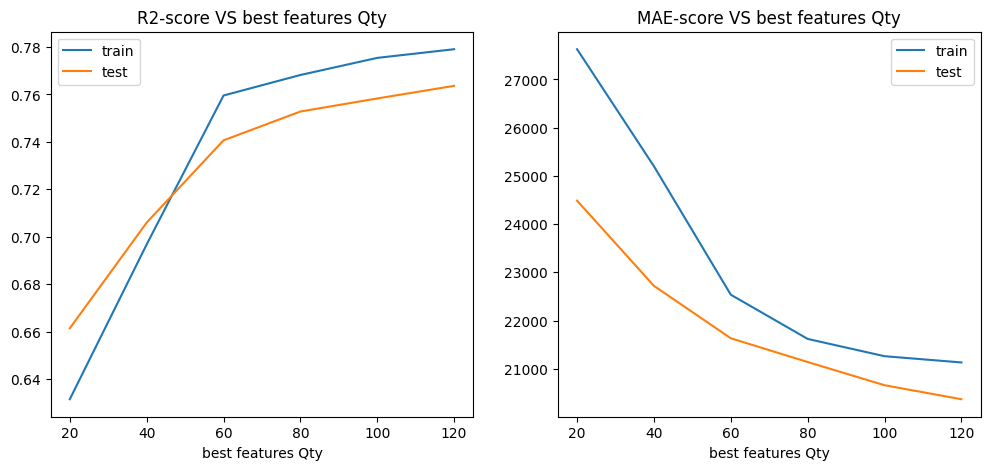

In [3968]:
f,a = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_r2, ax=a[0], label='train').set(title='R2-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_r2, ax=a[0], label='test');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_mae, ax=a[1], label='train').set(title='MAE-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_mae, ax=a[1], label='test');

In [3969]:
selector = SelectKBest(f_regression, k=120)
selector.fit(X_train, y_train_log)
 
best_fea = selector.get_feature_names_out()
best_fea

array(['Телефон', 'Баня', 'Гараж', 'Сад', 'Хозпостройки', 'Рядом лес',
       'Водоем', 'Теплица', 'Мебель', 'Камин', 'Строительные материалы',
       'Беседка', 'Новостройка', 'Бассейн', 'Элитный коттедж',
       'Пруд на участке', 'land_area', 'house_area', 'house_levels',
       'house_readiness', 'liv_house_area', 'kitchen_area',
       'distance_house_district_center', 'distance_house_region_min',
       'distance_house_minsk', 'Материал стен_дерево',
       'Материал стен_блок г/с', 'Материал стен_кирпич',
       'Материал стен_блок', 'Материал стен_сб-щитовой',
       'Материал стен_сруб', 'Материал стен_каркасн. дер.',
       'Материал стен_брус профил.', 'Материал стен_керамзитобетон',
       'Материал стен_дер., кирпич', 'Материал стен_брус клеен.',
       'Материал стен_каркасн. монол.', 'Материал крыши_шифер',
       'Материал крыши_черепица мет.', 'Материал крыши_черепица мяг.',
       'Материал крыши_ондулин', 'Материал крыши_металл',
       'Материал крыши_черепица', 'Ма

In [ ]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [3970]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[best_fea], y_train_log) 

y_train_pred = np.exp(gs.predict(X_train[best_fea]))
y_test_pred = np.exp(gs.predict(X_test[best_fea]))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.779
Train MAE: 21130.585
Train MAPE: 32.667


Test R^2: 0.764
Test MAE: 20367.747
Test MAPE: 41.426


In [ ]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('linr',  linear_model.LinearRegression())
    #('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    #final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()), ('linr', LinearRegression())],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        random_state=42))